In [1]:
# Song Liu (song.liu@bristol.ac.uk), 01-06-2023
# All rights reserved.

# load csv files from archive folder
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm 


class GenReg(ABC, nn.Module): 
    def __init__(self, loss = nn.HuberLoss(), regtype:str='fp'):
        super().__init__()
        self.loss = loss    
        if regtype == 'fp':
            self.test_labs = [0]
        elif regtype == 'tp':
            self.test_labs = [1]
        elif regtype == 'both':
            self.test_labs = [0, 1]
        else:
            raise ValueError('type should be one of fp, tp, both')
        self.regtype = regtype.lower()
    
    @abstractmethod
    def subgroup_reg(self, scores_1:Tensor, scores_2:Tensor):
        pass
    
    def forward(self, labels, scores, group_data):
        groups = torch.unique(group_data)
        loss = 0
        # Iterate over true label types
        for test_label in self.test_labs:
            # Iterate over protected groups
            for group in groups:
                group_score = scores[(group_data==group) & (labels==test_label)]
                loss += self.subgroup_reg(group_score, scores, test_label)
        return loss


class KDEReg(GenReg):
    a = 0.4920
    b = 0.2887
    c = 1.1893
    
    @staticmethod
    def F_est(y: Tensor)->Tensor:
        return torch.exp(-KDEReg.a*y**2 - KDEReg.b*y - KDEReg.c)
    
    def __init__(self, tau:int, h:int,logits=False, loss = nn.HuberLoss(), regtype:str='fp'):

        super().__init__(loss, regtype)
        self.tau = tau
        self.h = h
        self.logits=logits
    
    def subgroup_reg(self, scores_1:Tensor, scores_2:Tensor, test_label: int):
        # Cast onto [0,1] if necessary
        if self.logits:
            scores_1 = torch.sigmoid(scores_1)
            scores_2 = torch.sigmoid(scores_2)
        # Caclaulte kernel CDF estimates
        kernel_1 = torch.mean(self.F_est((self.tau-scores_1)/self.h)) - torch.mean(self.F_est((self.tau-scores_1)/self.h))
        kernel_2 = torch.mean(self.F_est((self.tau-scores_2)/self.h)) - torch.mean(self.F_est((self.tau-scores_2)/self.h))
        return self.loss(kernel_1, kernel_2)
    
class BCEReg(GenReg):
    def __init__(self, logit=False, loss = nn.HuberLoss(), regtype:str='fp'):
        super().__init__(loss, regtype)
        if logit:
            self.regloss = F.binary_cross_entropy_with_logits
        else:
            self.regloss = F.binary_cross_entropy
    def subgroup_reg(self, scores_1: Tensor, scores_2: Tensor, test_label:int):
        bce_1 = self.regloss(scores_1, torch.ones_like(scores_1)*test_label)
        bce_2 = self.regloss(scores_2, torch.ones_like(scores_2)*test_label)
        return self.loss(bce_1, bce_2)

ROC space is $[0,1]^2$, where the x axis is False Positive Rate (FPR) and y axis is True Positive Rate (TPR).

Recall, $\mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}$ and $\mathrm{FPR} = \frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}}$.

In [2]:

base = pd.read_csv('archive/Variant I.csv')
# For now filter to only get CA and CB employment_status values
# This is for simplicity and to be removed later.
base = base[base['employment_status'].isin(['CA', 'CB'])]
# remove 'income', 'customer_age', 'employment_status' columns as they are protected
sensitive = base[['income', 'customer_age', 'employment_status']]
employment_status = base['employment_status'].astype("category").cat.codes
base = base.drop(columns=['income', 'customer_age', 'employment_status'])
# convert categorical variables in 'payment_type' to integers
base['payment_type'] = base['payment_type'].astype('category')
base['housing_status'] = base['housing_status'].astype('category')
base['source'] = base['source'].astype('category')
base['device_os'] = base['device_os'].astype('category')

cat_columns = base.select_dtypes(['category']).columns
base[cat_columns] = base[cat_columns].apply(lambda x: x.cat.codes)
base_numpy = base.to_numpy()

X = base_numpy[:,1:]
y = base_numpy[:,0]
group = employment_status.to_numpy()

# class prior 
prior = np.sum(base_numpy[:,0])/len(base)

print('class prior for positive:', prior)
print('class prior for negative:', 1-prior)


X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(X, y, group, test_size=0.1, random_state=0)

class prior for positive: 0.0118026835742674
class prior for negative: 0.9881973164257326


In [3]:
def TPR(pred, label):
    TP = np.sum((pred==1) & (label==1))
    FN = np.sum((pred==0) & (label==1))
    return TP/(TP+FN)

def FPR(pred, label):
    FP = np.sum((pred==1) & (label==0))
    TN = np.sum((pred==0) & (label==0))
    return FP/(FP+TN)

def roc(pred, label, scores_probs=False):
    # If score are probabilities, we need to convert them to scores
    if scores_probs:
        pred = np.log(pred/(1-pred))
    fpr, tpr = [], []
    tmax = max(pred)
    tmin = min(pred)
    for t in np.linspace(tmin, tmax, 100):
        p = pred > t
        tpr.append(TPR(p, label))
        fpr.append(FPR(p, label))
    return fpr, tpr

def AUC(fpr, tpr):
    return sum([(tpr[i]+tpr[i-1])*(fpr[i-1]-fpr[i])/2 for i in range(1, len(fpr))])    

def aucloss(pred, label):
    if pred[label==1].shape[0] == 0: # you might end up with no positive samples
        print('no positive samples!')
    pos_pred = pred[label==1]
    neg_pred = pred[label==0]
    
    # hinge loss
    T = (neg_pred.T - pos_pred)
    loss = torch.max(T, torch.zeros_like(T))/2
    loss = torch.mean(loss, dim = 0)
    loss = torch.mean(loss)
    return loss

def paired_aucloss(pred, label):
    pos_pred = pred[label==1]
    neg_pred = pred[label==0]
    loss = F.relu(neg_pred - pos_pred)
    loss = torch.mean(loss)
    return loss

Do initial run of model. We will start with logitistic regression and $\tau=0.5$.

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_202383/565519512.py:14: RuntimeWarning: divide by zero encountered in log
  pred = np.log(pred/(1-pred))
/home/cn21903/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:134: RuntimeWarning: invalid value encountered in double_scalars
  delta = stop - start
 20%|██        | 1/5 [00:11<00:47, 11.99s/it]

1.340000033378601


 40%|████      | 2/5 [00:23<00:35, 11.75s/it]

1.2000000476837158


 60%|██████    | 3/5 [00:34<00:23, 11.55s/it]

1.0399999618530273


 80%|████████  | 4/5 [00:46<00:11, 11.45s/it]

0.9200000166893005


100%|██████████| 5/5 [00:57<00:00, 11.44s/it]

1.1399999856948853


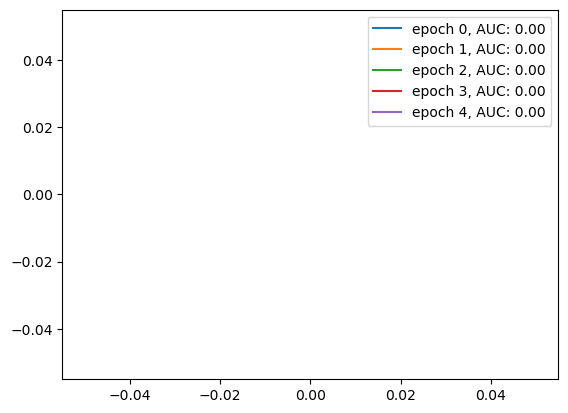

In [36]:
# Set up data
data = TensorDataset(
    torch.tensor(X_train).float(),
    torch.tensor(y_train).float(),
    torch.tensor(group_train).float())
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
model = nn.Sequential(nn.Linear(d, 1), nn.Sigmoid())
lossfunc = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
regularise = KDEReg(0.5, 0.01, regtype='fp')


fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        loss += 0*regularise(y, scores, group)
        loss.backward()
        optimizer.step()
    print(loss.item())
    pred_te = model(torch.tensor(X_test).float()).detach().numpy()[:,0]
    fpr, tpr = roc(pred_te, y_test, scores_probs=True)
    auc = AUC(fpr, tpr)
    ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
    
ax.legend()
plt.show()


Have score as linear then take logits in loss. This should make AUC calculation better. Now also check the 

 20%|██        | 1/5 [00:10<00:40, 10.24s/it]

16.718305587768555


 40%|████      | 2/5 [00:24<00:37, 12.41s/it]

8.636137962341309


 60%|██████    | 3/5 [00:35<00:24, 12.06s/it]

4.474161148071289


 80%|████████  | 4/5 [00:50<00:13, 13.06s/it]

2.065068483352661


100%|██████████| 5/5 [01:05<00:00, 13.05s/it]

0.31379434466362


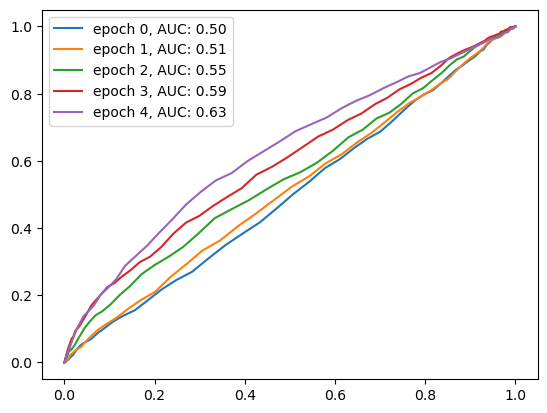

In [5]:
# Set up data
data = TensorDataset(
    torch.tensor(X_train).float(),
    torch.tensor(y_train).float(),
    torch.tensor(group_train).float())
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
model = nn.Linear(d, 1)
lossfunc = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
regularise = KDEReg(0.5, 0.01, regtype='fp', logits=True)


fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        loss += regularise(y, scores, group)
        loss.backward()
        optimizer.step()
    print(loss.item())
    pred_te = model(torch.tensor(X_test).float()).detach().numpy()[:,0]
    fpr, tpr = roc(pred_te, y_test)
    auc = AUC(fpr, tpr)
    ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
    
ax.legend()
plt.show()


# To do
Try with paired AUC as loss

  0%|          | 0/5 [00:00<?, ?it/s]/home/cn21903/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 20%|██        | 1/5 [00:11<00:44, 11.20s/it]

1.3014616966247559


 40%|████      | 2/5 [00:22<00:33, 11.10s/it]

1.3024617433547974


 60%|██████    | 3/5 [00:36<00:25, 12.52s/it]

1.2992616891860962


 80%|████████  | 4/5 [00:51<00:13, 13.59s/it]

1.3023617267608643


100%|██████████| 5/5 [01:05<00:00, 13.17s/it]

1.3005616664886475


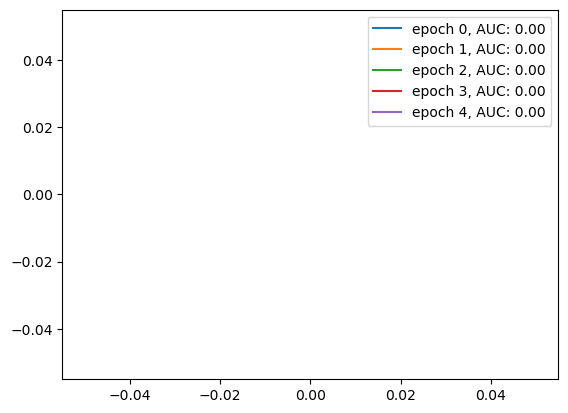

In [ ]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
group_train0 = group_train[y_train==0]
group_train1 = group_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    torch.tensor(X_train0).float(),
    torch.tensor(y_train[y_train==0]).float(),
    torch.tensor(group_train0).float())
data1 = TensorDataset(
    torch.tensor(X_train1).float(),
    torch.tensor(y_train[y_train==1]).float(),
    torch.tensor(group_train1).float()) 

# Set-up model
d = X_train.shape[1]
model = nn.Linear(d, 1)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
regularise = KDEReg(0.5, 0.01, regtype='fp', logits=True)


fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for (x0, y0, group0), (x1,y1,group_1) in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        loss += 0*regularise(y, scores, group)
        loss.backward()
        optimizer.step()
    print(loss.item())
    pred_te = model(torch.tensor(X_test).float()).detach().numpy()[:,0]
    fpr, tpr = roc(pred_te, y_test)
    auc = AUC(fpr, tpr)
    ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
    
ax.legend()
plt.show()
